In [1]:
from sympy import *
init_printing()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro,ET0
time,,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18,36.289050
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14,24.390254
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60,60.468354
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15,56.266438
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78,0.986866


In [3]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

In [4]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to perform the ADF test and display results
def adf_test(series, name='Series', signif=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    output = pd.Series(result[0:4], index=[
        'ADF Statistic', 'p-value', '# Lags Used', 'Observations'
    ])
    for key, val in result[4].items():
        output[f'Critical Value ({key})'] = val
    print(f'Augmented Dickey–Fuller Test for {name}:')
    print(output.to_string())
    if result[1] <= signif:
        print(f"=> {name} is stationary (p ≤ {signif}).\n")
    else:
        print(f"=> {name} is non-stationary (p > {signif}).\n")

# Run ADF test on the original KarupBro series
adf_test(df[target_col], name='KarupBro')

# If non-stationary, difference once and re-test
df['KarupBro_diff'] = df[target_col].diff()
adf_test(df['KarupBro_diff'], name='KarupBro (1st diff)')

Augmented Dickey–Fuller Test for KarupBro:
ADF Statistic          -8.417057e+00
p-value                 2.030321e-13
# Lags Used             3.200000e+01
Observations            7.995000e+03
Critical Value (1%)    -3.431168e+00
Critical Value (5%)    -2.861902e+00
Critical Value (10%)   -2.566962e+00
=> KarupBro is stationary (p ≤ 0.05).

Augmented Dickey–Fuller Test for KarupBro (1st diff):
ADF Statistic            -21.969113
p-value                    0.000000
# Lags Used               31.000000
Observations            7995.000000
Critical Value (1%)       -3.431168
Critical Value (5%)       -2.861902
Critical Value (10%)      -2.566962
=> KarupBro (1st diff) is stationary (p ≤ 0.05).



Augmented Dickey–Fuller Test for Deseasonalized KarupBro:
ADF Statistic          -1.071181e+01
p-value                 3.317079e-19
# Lags Used             3.200000e+01
Observations            7.995000e+03
Critical Value (1%)    -3.431168e+00
Critical Value (5%)    -2.861902e+00
Critical Value (10%)   -2.566962e+00
=> Deseasonalized KarupBro is stationary (p ≤ 0.05).



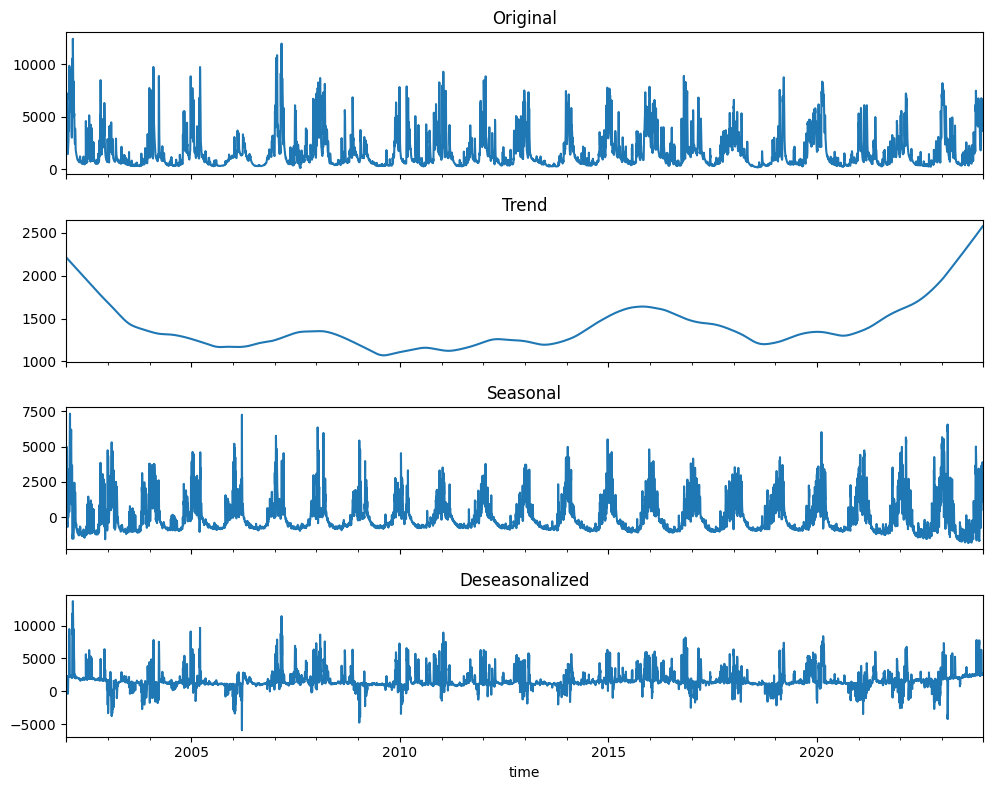

In [7]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

y = df['KarupBro']

stl = STL(y, period=365, robust=True)   # period=365 for daily data; adjust if needed
res = stl.fit()
df['seasonal'] = res.seasonal
df['deseasonalized'] = y - res.seasonal

# Optional: visualize
fig, axes = plt.subplots(4,1, figsize=(10,8), sharex=True)
y.plot(ax=axes[0], title='Original'); 
res.trend.plot(ax=axes[1], title='Trend')
res.seasonal.plot(ax=axes[2], title='Seasonal')
df['deseasonalized'].plot(ax=axes[3], title='Deseasonalized')
plt.tight_layout()


# --- 4) Test stationarity on deseasonalized ---
adf_test(df['deseasonalized'], name='Deseasonalized KarupBro')